# Time-Domain Simulation and Plotting

## Run Time-Domain Simulation

In [1]:
import andes

from andes.utils.paths import get_case

### Run power flow by default

In [2]:
ss = andes.run(get_case('kundur/kundur_full.xlsx'))

Working directory: "/Users/hcui7/repos/andes/examples"
Loaded config from file "/Users/hcui7/.andes/andes.rc"
Undilled calls are for version 0.9.2.post3+ga532487b, regenerating...


Parsing input file "/Users/hcui7/repos/andes/andes/cases/kundur/kundur_full.xlsx"
Input file parsed in 0.0631 seconds.

-> Power flow calculation
Sparse Solver: KLU
Method: NR method
Power flow initialized.
0: |F(x)| = 14.9283   
1: |F(x)| = 3.60858   
2: |F(x)| = 0.17009   
3: |F(x)| = 0.00203822
4: |F(x)| = 3.76399e-07
Converged in 5 iterations in 0.0107 seconds.
Report saved to "kundur_full_out.txt" in 0.0025 seconds.
-> Single process finished in 4.8337 seconds.


### Run time-domain simulation 
Run TDS by calling `TDS.run()` on the system. Note that the call must follow the power flow immediately.

The default simulation is for 20 seconds. To change if, change ``config.tf`` to the desired value.

In [3]:
ss.TDS.config.tf = 30  # simulate for 10 seconds

In [4]:
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0-30sec.
Fixed step size: h=33.33msec., shrink if not converged
Initialization was successful in 0.0116 seconds.


<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.         
100%|████████████████████████████████| 100/100 [00:02<00:00, 47.98%/s]

Simulation completed in 2.0847 seconds.
TDS outputs saved in 0.0091 seconds.


True

## Plot Results

A `Plotter` object is created for `TDS`. It uses the same API as the command-line plot.

`plotter.plot()` is a method for plotting. 

### Index lookup

Before plotting, open the `kundur_full_out.lst` to find the indices (first column) for the variables to plot.

For example, if we want to plot all generator speed, which is the `omega` variable of `GENROU`. 
From inspect, we know the indices are `5, 6, 7, 8`. Pass them in a tuple to `plotter.plot`.

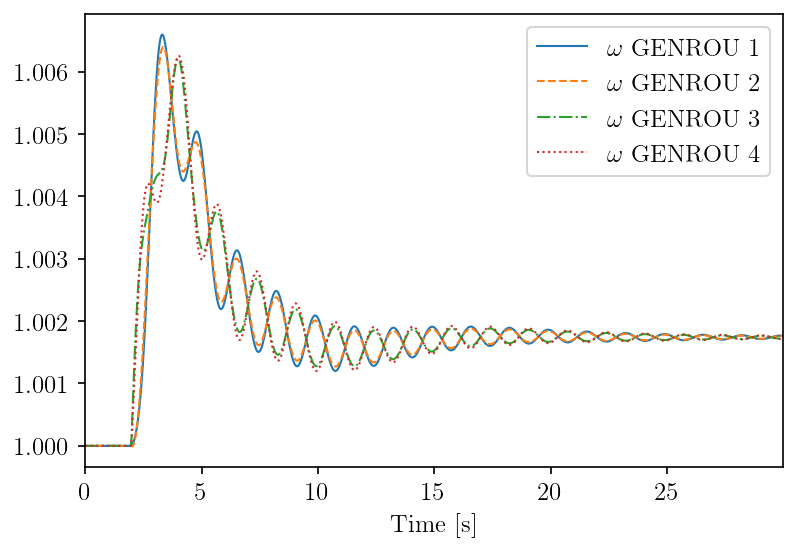

In [5]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8))

### Find index by variable name

`plotter.find()` is a method for finding indices based on variable name.

The first argument is the pattern to find. An optional argument `exclude` is the pattern to exclude. Regular expression is supported for both.

In [6]:
ss.TDS.plotter.find('omega')

([5, 6, 7, 8],
 ['omega GENROU 1', 'omega GENROU 2', 'omega GENROU 3', 'omega GENROU 4'])

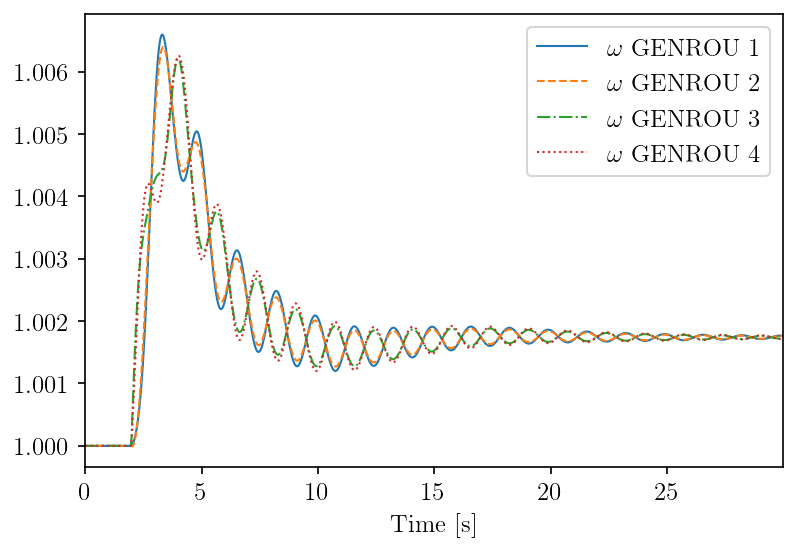

In [7]:
fig, ax = ss.TDS.plotter.plot(ss.TDS.plotter.find('omega')[0])

### Y-axis label

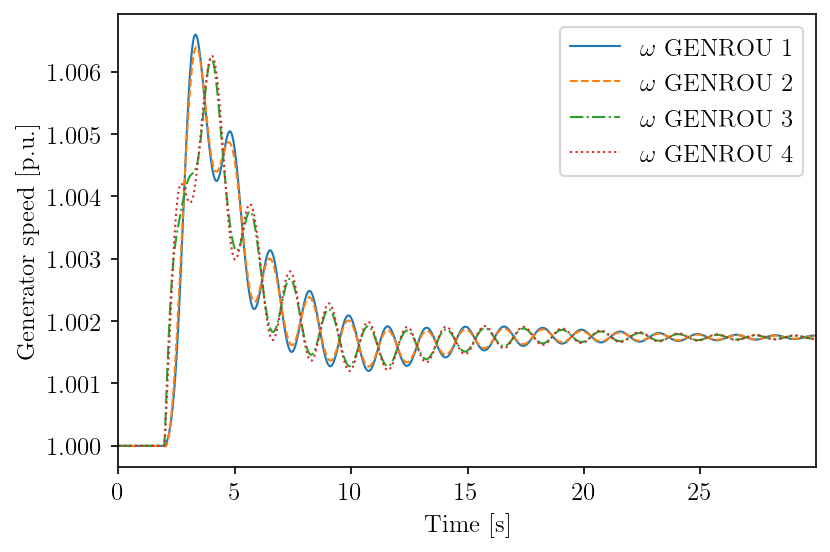

In [8]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), ylabel='Generator speed [p.u.]')

### Scaling

A lambda functino can be passed to `ycalc` to scale the value. To scale the frequency from per unit to 60 Hz nominal values, use

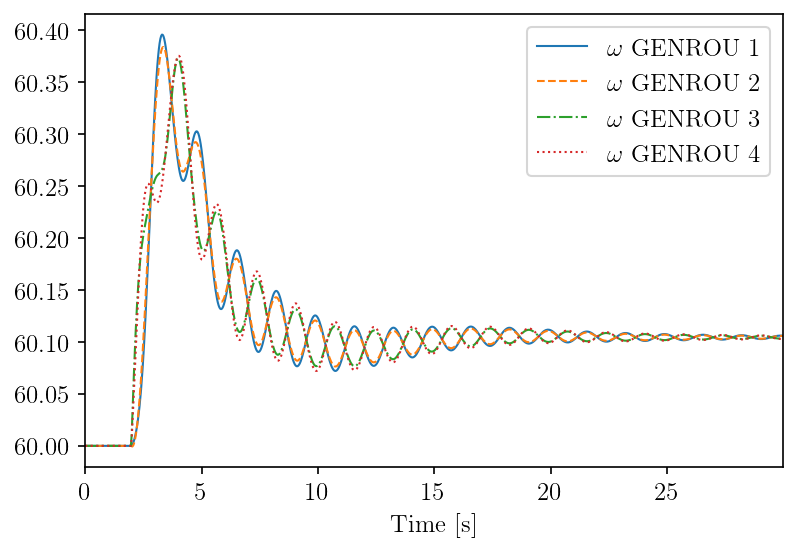

In [9]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), ycalc=lambda x: 60 * x)

### Greyscale and Grid

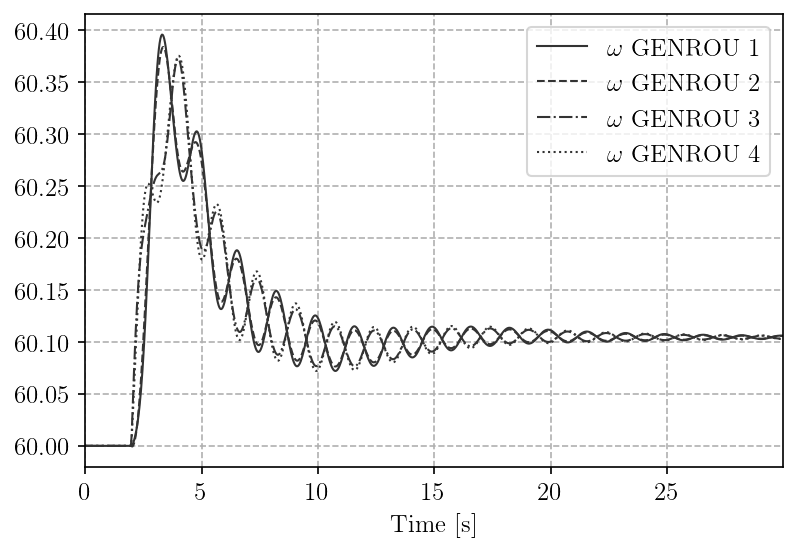

In [10]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8),
                              ycalc=lambda x: 60 * x,
                             greyscale=True,
                             grid=True)

### Save figure

Pass `savefig = True` to save the figure to a `png` file. 

Figure saved to "kundur_full_1.png".


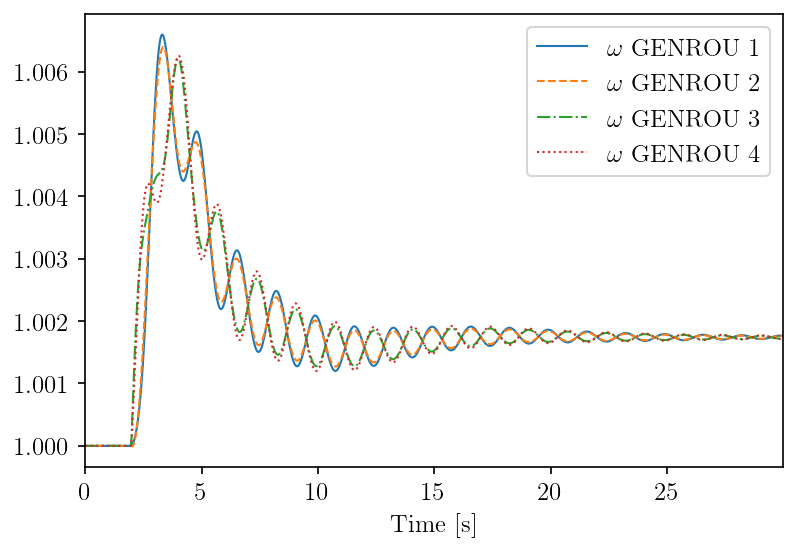

In [11]:
fig, ax = ss.TDS.plotter.plot((5, 6, 7, 8), savefig=True)

### Additional arguments

`plotter.plot` takes addition arguments. To check additional arguments, please use `help` or refer to the source code.

In [12]:
help(ss.TDS.plotter.plot)

Help on method plot in module andes.plot:

plot(yidx, xidx=(0,), a=None, ycalc=None, left=None, right=None, ymin=None, ymax=None, ytimes=None, xlabel=None, ylabel=None, legend=True, grid=False, greyscale=False, latex=True, dpi=150, line_width=1.0, font_size=12, savefig=None, save_format=None, show=True, use_bqplot=False, latex_warn=True, **kwargs) method of andes.plot.TDSData instance
    Entery function for plot scripting. This function retrieves the x and y values based
    on the `xidx` and `yidx` inputs and then calls `plot_data()` to do the actual plotting.
    
    Note that `ytimes` and `ycalc` are applied sequentially if apply.
    
    Refer to `plot_data()` for the definition of arguments.
    
    Parameters
    ----------
    xidx : list or int
        The index for the x-axis variable
    
    yidx : list or int
        The indices for the y-axis variables
    
    Returns
    -------
    (fig, ax)
        Figure and axis handles



In [13]:
help(ss.TDS.plotter.plot_data)

Help on method plot_data in module andes.plot:

plot_data(xdata, ydata, xheader=None, yheader=None, xlabel=None, ylabel=None, line_styles=None, left=None, right=None, ymin=None, ymax=None, legend=True, grid=False, fig=None, ax=None, latex=True, dpi=150, line_width=1.0, font_size=12, greyscale=False, savefig=None, save_format=None, show=True, latex_warn=True, **kwargs) method of andes.plot.TDSData instance
    Plot lines for the supplied data and options. This functions takes `xdata` and `ydata` values. If
    you provide variable indices instead of values, use `plot()`.
    
    Parameters
    ----------
    xdata : array-like
        An array-like object containing the values for the x-axis variable
    
    ydata : array
        An array containing the values of each variables for the y-axis variable. The row
        of `ydata` must match the row of `xdata`. Each column correspondings to a variable.
    
    xheader : list
        A list containing the variable names for the x-axis v

## Cleanup

In [14]:
! andes misc -C


    _           _         | Version 0.9.2.post1+g7283d31e
   /_\  _ _  __| |___ ___ | Python 3.7.1 on Darwin, 05/04/2020 10:21:20 PM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

<kundur_full_out.txt> removed.
<kundur_full_out.npy> removed.
<kundur_full_out.lst> removed.
